# Probabilistic Principal Component Analysis (PPCA)

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.linalg import eigh, inv
from sklearn.datasets import load_iris

In [3]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(precision=4, suppress=True)

* <span style="color:crimson">PPCA correctly captures the variance of the data along the principal axes, and approximates the varianace in all remaining directions with a single average value $\sigma^2$</span>

* PPCA is principal component analysis as the Maximum Likelihood solution of a probabilistic latent variable model

* In PPCA, we map from latent space to data space using

$$
    {\bf x}\vert{\bf z} = W{\bf z} + {\boldsymbol\mu} + \boldsymbol\epsilon
$$

Where

1. ${\bf z}$ is a latent variable that models the <span style="color:crimson">principal-component subspace</span>.
2. ${\bf x}$ is the observed variable 
3. $\boldsymbol\epsilon \sim \mathcal{N}\left({\bf 0}, \sigma^2{\bf I}\right)$

and we assume 

$$
    p({\bf z}) = \mathcal{N}\left(z\vert{\bf 0}, {\bf I}\right)
$$

$$
    p({\bf x} \vert {\bf z}) = \mathcal{N}\left({\bf x} \vert W{\bf z} + {\boldsymbol\mu}, \sigma^2{\bf I}\right)
$$

## Maximum Likelihood PCA

For probabilistic PCA, the maximum likelihood parameters are given by

$$
    {\boldsymbol\mu}_{ML} = \bar{\bf x}
$$

$$
    {\bf W}_{ML} = {\bf U}_M({\bf L}_M - \sigma_{ML}^2{\bf I})^{1/2}{\bf R}
$$

$$
    \sigma^2_{ML} = \frac{1}{D - M}\sum_{m=M+1}^D\lambda_m
$$

Where:
*  ${\bf U}_M$ is an $D \times M$ matrix whose columns are given by the $M$ eigenvectors with corresponding largest $M$ eigenvalues
* ${\bf L}_M$ is a diagonal $M\times M$ matrix of the corresponding eigenvectors
* ${\bf R}$ is an arbitrary orthogonal $M\times M$ matrix

In [4]:
iris = load_iris()
X, y = iris["data"], iris["target"]

M = 2
N, D = X.shape
S = np.cov(X.T)

In [5]:
L, U = eigh(S)
L, U = L[::-1], U[:, ::-1]

Lm = np.identity(M) * L[:M]

In [6]:
mu = X.mean(axis=0)
sigma2 = L[M:].sum() / (D - M)
W = U[:, :M] @ np.sqrt(Lm - sigma2 * np.identity(M))

### Projecting down to $\mathbb{R}^M$

The posterior distributior over the latent space is given by

$$
    p({\bf z}|{\bf x}) = \mathcal{N}\left({\bf M}^{-1}{\bf W}^T({\bf x} - \boldsymbol\mu), \sigma^{-2}{\bf M}\right)
$$

Hence, *expected* projection down to $\mathbb{R}^M$ is given by

$$
    \mathbb{E}[{\bf z} | {\bf x}] = {\bf M}^{-1}{\bf W}^T_{\text{ML}}({\bf x} - \bar{\bf x})
$$

Where

* ${\bf M} = {\bf W}^T{\bf W} + \sigma^2 {\bf I}$.

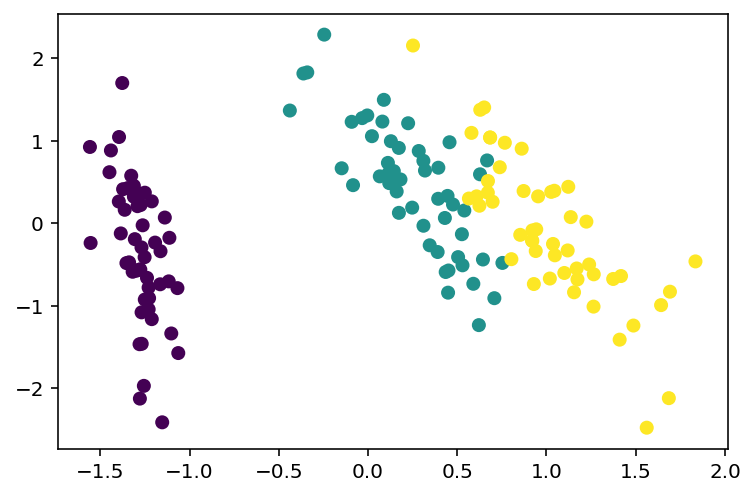

In [7]:
Mx = W.T @ W + sigma2 * np.identity(M)

Ez = inv(Mx) @ W.T @ (X - mu).T

plt.scatter(*Ez, c=y);

## PPCA and the EM algorithm

An alternate way to estimate the parameters of the probabilistic PCA model is via the EM algorithm by considering the latent variable ${\bf z}_n$.

For PPCA, the expected value of the complete data log-likelihood with respect to the posterior latent distribution $Q = \mathbb{E}\left[\log p\left({\bf X}, {\bf Z}|\boldsymbol\mu, {\bf W}, \sigma^2\right)\right]$ is given by

$$
\begin{align}
    Q &=-\sum_{n=1}^N\Big\{\frac{M}{2}\log 2\pi + \text{Tr}\left(\mathbb{E}[{\bf z}_n{\bf z}_n^T]\right) + \frac{D}{2} \log2\pi\sigma^2\\
    %% Second term
    & + \frac{1}{2\sigma^2}\vert\vert{\bf x}_n - \bar{\bf x}\vert\vert - \frac{1}{\sigma^2}\mathbb{E}[{\bf z}_n]^T{\bf W}^T({\bf x}_n - \bar{\bf x}) + \frac{1}{\sigma^2}\text{Tr}\left(\mathbb{E}[{\bf z}_n{\bf z}_n^T]{\bf W}^T{\bf W}\right)\Big\}
\end{align}
$$


Recalling that $p({\bf z} \vert {\bf x}) = \mathcal{N}\left({\bf z}\vert {\bf M}^{-1}{\bf W}^T({\bf x}_n - \bar{\bf x}), \sigma^{-1}{\bf M}\right)$; ${\bf M} = {\bf W}^T{\bf W} + \sigma^2{\bf I}$ we obtain the following updating statistics:

$$
    \mathbb{E}[{\bf z}_n] = {\bf M}^{-1}{\bf W}^T({\bf x}_n - \bar{\bf x})
$$

$$
    \mathbb{E}\left[{\bf z}_n{\bf z}_n^T\right] = \mathbb{E}[{\bf z}_n]\mathbb{E}[{\bf z}_n]^T + \sigma^{-2}{\bf M}^{-1}
$$

Next, taking the derivative of $Q$ w.r.t. $\sigma^2$ and $\bf W$ and noting that $\mu_{\text{ML}} = \bar{\bf x}$, we obtain the updating equations:

$$
    \sigma_{\text{new}} = \frac{1}{ND}\sum_{n=1}^N \left\{\vert\vert{\bf x}_n - \bar{\bf x}\vert\vert^2 - 2\mathbb{E}[{\bf z}_n]^T{\bf W}^T({\bf x}_n - \bar{\bf x}) + \text{Tr}\left(\mathbb{E}[{\bf z}_n{\bf z}_n^T]{\bf W}^T{\bf W}\right)\right\}
$$

$$
    {\bf W}_{\text{new}} = \left(\sum_{n=1}^N\left({\bf x}_n - \bar{\bf x}_n\right)\mathbb{E}[{\bf z}_n]^T\right)\left(\sum_{n=1}^N\mathbb{E}\left[{\bf z}_n{\bf z}_n^T\right]\right)^{-1}
$$

Thus, we obtain the following updating equations
* **E**-step: Compute the sufficient statistics $\mathbb{E}\left[{\bf z}_n\right]$ and $\mathbb{E}\left[{\bf z}_n{\bf z}_n^T\right]$ considering the values ${\bf W}_\text{old}$ and $\sigma^2_\text{old}$
* **M**-step: Update ${\bf W}_\text{old}$, $\sigma^2_\text{old}$

### MNIST Example

In [8]:
mnist = tf.keras.datasets.mnist.load_data()
(Xtrain, ytrain), (Xtest, ytest) = mnist

In [9]:
N, D, D = Xtrain.shape
X = Xtrain.reshape(N, -1)
N, D = X.shape

Xhat = X - X.mean(axis=0)

In [10]:
M = 2
W = np.random.randn(D, M)
sigma2 = 0.5

In [11]:
# Helper posterior distribution matrix
Mz = W.T @ W + sigma2 * np.identity(M)

In [12]:
%%time
## equivalent: E_zn = inv(Mz) @ W.T @ X.T
E_zn = np.einsum("ij,mj,km->ik", inv(Mz), W, Xhat, optimize=True)
E_znzn = np.einsum("in,kn->kin", E_zn, E_zn, optimize=True) + inv(Mz)[..., None] / sigma2

CPU times: user 111 ms, sys: 3.7 ms, total: 115 ms
Wall time: 30.4 ms


####  $\sigma_\text{new}^2$ components

$$
\sum_{n=1}^N \vert\vert{\bf x}_n - \bar{\bf x}\vert\vert^2
$$

In [13]:
%%time
Xnorm2 = (Xhat ** 2).sum()

CPU times: user 694 ms, sys: 118 ms, total: 813 ms
Wall time: 249 ms


$$
-2\sum_{n=1}^N \left\{\mathbb{E}[{\bf z}_n]^T{\bf W}^T({\bf x}_n - \bar{\bf x})\right\}
$$

In [14]:
%%time
T2 = - 2 * np.einsum("in,mi,nm->", E_zn, W, Xhat, optimize=True)

CPU times: user 161 ms, sys: 2.73 ms, total: 164 ms
Wall time: 40.8 ms


$$
\sum_{n=1}^N \left\{\text{Tr}\left(\mathbb{E}[{\bf z}_n{\bf z}_n^T]{\bf W}^T{\bf W}\right)\right\}
$$

In [15]:
%%time
T3 = np.einsum("ijn,mi,mj->", E_znzn, W, W, optimize="optimal")

CPU times: user 9.19 ms, sys: 1.98 ms, total: 11.2 ms
Wall time: 2.48 ms


In [16]:
sigma2_new = (Xnorm2 + T2 + T3) / (N * D)
sigma2_new

4361.30349399611

---

#### ${\bf W}_\text{new}$ components

$$
\sum_{n=1}^N\left({\bf x}_n - \bar{\bf x}_n\right)\mathbb{E}[{\bf z}_n]^T
$$

In [17]:
%%time
T1 = np.einsum("nd,mn,jmn->dj", Xhat, E_zn, E_znzn, optimize="optimal")

CPU times: user 139 ms, sys: 2.25 ms, total: 141 ms
Wall time: 35.9 ms


$$
\sum_{n=1}^N\mathbb{E}\left[{\bf z}_n{\bf z}_n^T\right]
$$

In [18]:
%%time
T2 = E_znzn.sum(axis=-1)

CPU times: user 5.98 ms, sys: 1.04 ms, total: 7.03 ms
Wall time: 1.53 ms


In [19]:
W_new = (T1 @ inv(T2))

### All together

In [20]:
class ProbabilisticPCA:
    """
    Implementation of the Probabilistic PCA (PPCA) algorithm
    in which we assume that a datapoint in drawn from a latent
    variable z R^M, shifted via a parameter mu, and then projected
    onto R^D via the projecting matrix W plus some additive noise
    sigma2. Hence
    
        x = Wz + mu + eps; eps ~ N(0, sigma2)
        
    """
    def __init__(self, X, M, W_init=None, sigma2_init=None, seed=None):
        self.seed = seed
        self.M = M
        self.N, self.D = X.shape
        self.Xbar = X - X.mean(axis=0)
        self.Xnorm2 = (self.Xbar ** 2).sum()
        self.W = self._initialize_W(W_init)
        self.sigma2 = self._initialize_sigma2(sigma2_init)
        self.E_zn, self.E_znzn = self._compute_expectations()
        
    
    def _initialize_W(self, W_init):
        np.random.seed(self.seed)
        if W_init is None:
            return np.random.randn(self.D, self.M)
        else:
            return W_init
        
        
    def _initialize_sigma2(self, sigma2_init):
        np.random.seed(self.seed)
        if sigma2_init is None:
            return np.random.rand()
        else:
            return sigma2_init
        
        
    def _compute_expectations(self):
        """
        :::E-Step:::

        Compute ∀n in the dataset. E[zn], E[zn@zn.T]
        """
        Mz = self.W.T @ self.W + self.sigma2 * np.identity(self.M)
        i_Mz = inv(Mz)
        
        E_zn = np.einsum("ij,mj,km->ik", i_Mz, self.W, self.Xbar, optimize=True)
        E_znzn = np.einsum("in,kn->kin", E_zn, E_zn, optimize=True) + i_Mz[..., None] / self.sigma2
        
        return E_zn, E_znzn
    
    
    def update_sigma2(self):
        T2 = - 2 * np.einsum("in,mi,nm->", self.E_zn, self.W, self.Xbar, optimize=True)
        T3 = np.einsum("ijn,mi,mj->", self.E_znzn, self.W, self.W, optimize="optimal")
        sigma2_new = (self.Xnorm2 + T2 + T3) / (self.N * self.D)
        
        return sigma2_new
    
    
    def update_W(self):
        T1 = np.einsum("nd,mn,jmn->dj", self.Xbar,
                       self.E_zn, self.E_znzn, optimize="optimal")
        T2 = self.E_znzn.sum(axis=-1)
        
        W_new = (T1 @ inv(T2))
        
        return W_new
    
    
    def _update_parameters(self):
        """
        :::M-step:::
        
        Compute one step of the EM-algorithm
        (assuming that the E-step has already been)
        computed
        """
        sigma2_new = self.update_sigma2()
        W_new = self.update_W()
        
        return sigma2_new, W_new
        
        
    def data_log_likelihood(self):
        """
        Compute the expected value of the complete-data log-likelihood
        with respect to the posterior distribution of the latent
        variable
        """
        Q = -(self.N * self.M * np.log(2 * np.pi) / 2 +
              np.einsum("iin->", self.E_znzn) + 
              D * np.log(2 * np.pi * self.sigma2) / 2 +
              self.Xnorm2 / (2 *  self.sigma2) +
              -np.einsum("in,mi,nm->", self.E_zn, self.W, self.Xbar, optimize=True) / (self.sigma2) + 
              np.einsum("ijn,mi,mj->", self.E_znzn, self.W, self.W, optimize="optimal") / (self.sigma2)
              )
        
        return Q
    
    def project(self):
        Mz = self.W.T @ self.W + self.sigma2 * np.identity(self.M)
        Xproj = inv(Mz) @ self.W.T @ self.Xbar.T
        return Xproj
    
    def EM_step(self):
        # E-step
        self.E_zn, self.E_znzn = self._compute_expectations()
        # M-step
        self.sigma2, self.W = self._update_parameters()
        
        Q = self.data_log_likelihood()
        return Q

$$
\begin{align}
    Q &=-\sum_{n=1}^N\Big\{\frac{M}{2}\log 2\pi + \text{Tr}\left(\mathbb{E}[{\bf z}_n{\bf z}_n^T]\right) + \frac{D}{2} \log2\pi\sigma^2\\
    %% Second term
    & + \frac{1}{2\sigma^2}\vert\vert{\bf x}_n - \bar{\bf x}\vert\vert^2 - \frac{1}{\sigma^2}\mathbb{E}[{\bf z}_n]^T{\bf W}^T({\bf x}_n - \bar{\bf x}) + \frac{1}{\sigma^2}\text{Tr}\left(\mathbb{E}[{\bf z}_n{\bf z}_n^T]{\bf W}^T{\bf W}\right)\Big\}
\end{align}
$$



In [21]:
M = 2
ppca = ProbabilisticPCA(X, M, sigma2_init=10, seed=2718)

nits = 30
Qhist = [ppca.data_log_likelihood()]
list_projections = [ppca.project()]
for n in range(nits):
    Q = ppca.EM_step()
    *_, Qlast = Qhist
    Qhist.append(Q)
    
    if (Q / Qlast < 1e-3) and not np.isinf(Qlast):
        break
    list_projections.append(ppca.project())

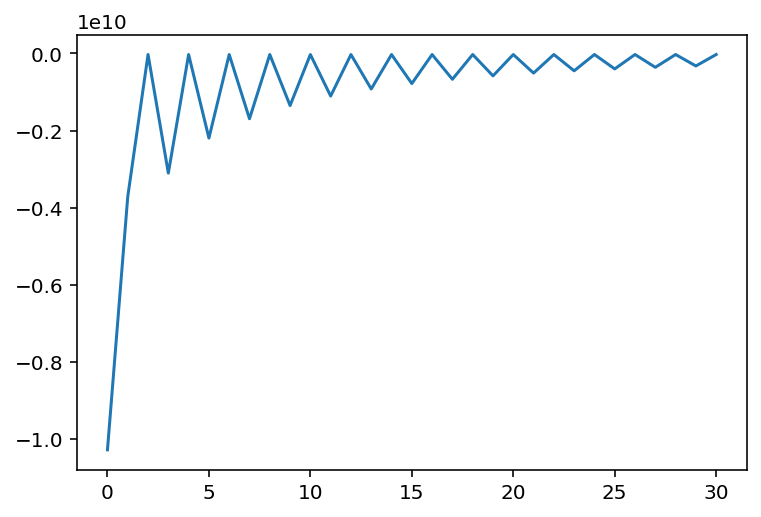

In [22]:
plt.plot(Qhist)

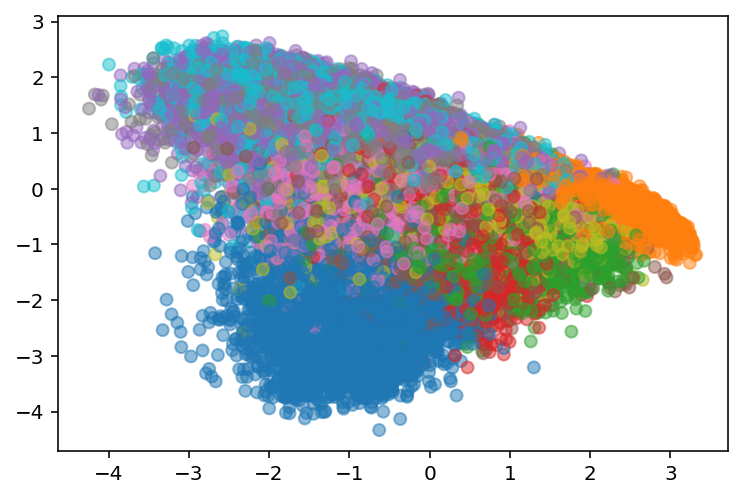

In [23]:
plt.scatter(*ppca.project(), c=ytrain, cmap="tab10", alpha=0.5)

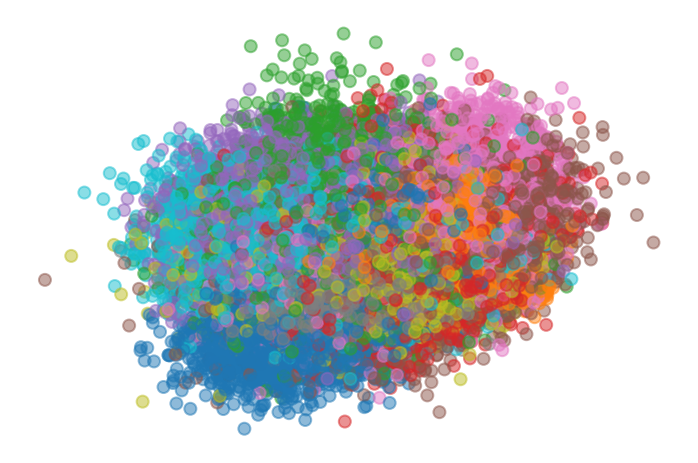

In [24]:
import matplotlib.animation as animation

nframes = 10
save_animation = False
fig, ax = plt.subplots()
def func(i):
    plt.cla()
    projection = list_projections[i]
    ax.scatter(*projection, c=ytrain, cmap="tab10", alpha=0.5)
    plt.axis("off")

ani = animation.FuncAnimation(fig, func, frames=nframes)
    
    
if save_animation == True:
    ani.save("/Users/gerardoduran/Desktop/ppca2.gif", writer="imagemagick")

## Handling Missing Data

PPCA can be used in datasets in which some of the data values are missing at random. In order to take account of the missing data, we require to compute the **expectation of the complete-data log-likelihood with respect to the posterior latent-variable distribution and the posterior over the missing values in the data**.

Let ${\bf x}$ be an observed vector with missing entries ${\bf x}^{\text{miss}}$ and observed entries ${\bf x}^{\text{obs}}$. So that ${\bf x} = \left({\bf x}^{\text{obs}}, {\bf x}^{\text{miss}}\right)^T$. The expected value of the complete-data log-likelihood is given by


$$
\begin{aligned}
    \mathbb{E}\left[\log p\left({\bf X}, {\bf Z}\right)\right] &= -\sum_{n=1}^N\iint\log p\left({\bf x}_n, {\bf z}_n \vert \boldsymbol{\mu}, {\bf W}, \sigma^2\right) p\left({\bf z}_n\vert {\bf x}_n^{\text{miss}}\right) p\left({\bf x}_n^k\vert {\bf x}_n^{\text{miss}}\right) {\text d}{\bf x}_n^{\text{miss}} {\text d}{\bf z}_n\\
    %% Second equality
    &=-\sum_{n=1}^N\Big\{\frac{M}{2}\log 2\pi + \text{Tr}\left(\mathbb{E}[{\bf z}_n{\bf z}_n^T]\right) + \frac{D}{2} \log2\pi\sigma^2\\
    %% Second term
    & + \frac{1}{2\sigma^2}\left(\text{Tr}({\bf C}_{\text{miss}\vert\text{obs}}\right) + \vert\vert{\bf x}_n^{\text{obs}} - \bar{\bf x}^{\text{obs}}\vert\vert^2) - \frac{1}{\sigma^2}\mathbb{E}[{\bf z}_n]^T{\bf W}^T\left(\mathbb{E}[{\bf x}_n] - \bar{\bf x}\right) + \frac{1}{\sigma^2}\text{Tr}\left(\mathbb{E}[{\bf z}_n{\bf z}_n^T]{\bf W}^T{\bf W}\right)\Big\}
\end{aligned}
$$



The probabililty of missing data given the observed data will be normally distributed with mean $\mu_{\text{miss}\ \vert\text{obs}}$ and covariance matrix ${\bf C}_{\text{miss}\ \vert\text{obs}}$

$$
    \boldsymbol\mu_{\text{miss}\vert\text{obs}} = \boldsymbol\mu_{\text{miss}} + {\bf C}_{\text{miss}, \text{obs}}{\bf C}_{\text{obs}}^{-1}\left({\bf x}_{\text{obs}} - \boldsymbol\mu_{\text{obs}}\right)
$$

$$
    {\bf C}_{\text{miss}\vert\text{obs}} =  {\bf C}_\text{miss} - {\bf C}_{\text{miss},\text{obs}}{\bf C}_{\text{obs}^{-1}}{\bf C}_{\text{miss},\text{obs}}^T
$$

Where

* ${\boldsymbol\mu_\text{miss}}$ is the average value of the columns in the dataset ${\bf X}$ that are missing in ${\bf x}_n$
* ${\bf C}_{\text{miss}\vert\text{obs}}$

In [403]:
from numba import jit
from numpy.random import randint, seed
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA

breast_cancer = load_breast_cancer()
N, D = X_bc.shape
X_bc, y_bc = breast_cancer["data"], breast_cancer["target"]

X_bc.shape

(569, 30)

In [405]:
# Suppose we are missing 10% of the data
seed(314)
Nmiss = int(N * 0.1)
ix_miss_rows = randint(0, N, size=Nmiss)
ix_miss_cols = randint(0, D, size=Nmiss)
X_bc[ix_miss_rows, ix_miss_cols] = np.nan

In [406]:
mu = np.nanmean(X_bc, axis=0)

In [407]:
# Initial model parameters
M = 2
W = np.random.randn(D, M)
sigma2 = 2

In [408]:
ixmiss = np.isnan(X_bc).sum(axis=1).argmax()
Xsamp = X_bc[ixmiss]
c_miss = np.isnan(Xsamp) # missing columns of an observation
D_miss = c_miss.sum() # number of missing dimensions

In [409]:
X_miss = Xsamp[c_miss]
X_obs = Xsamp[~c_miss]

In [410]:
W_miss = W[c_miss]
W_obs = W[~c_miss]

In [411]:
C_miss = W_miss @ W_miss.T + sigma2 * np.identity(D_miss)
C_obs = W_obs @ W_obs.T + sigma2 * np.identity(D - D_miss)
C_miss_obs = W_miss @ W_obs.T

In [412]:
mu_miss = mu[c_miss]
mu_obs = mu[~c_miss]

In [413]:
mu_miss_giv_obs = C_miss_obs @ inv(C_obs) @ (X_obs - mu_obs)[:, np.newaxis]

The computation of the expectations $\mathbb{E}\left[\vert\vert {\bf x}_n - \boldsymbol\mu\vert\vert^2\right]$ and $\mathbb{E}[{\bf x}_n]$ are not vectorizable, as each $n$ will yield vectors $\boldsymbol\mu_{\text{miss}}$ and $\boldsymbol\mu_{\text{obs}}$ of diferent lenght. Hence, we will define functions to compute $\sum_{n=1}^N \mathbb{E}[{\bf x}_n]$ and $\sum_{n=1}^N \mathbb{E}\left[\vert\vert {\bf x}_n - \boldsymbol\mu\vert\vert^2\right]$.

In [414]:
ixmiss, *_ = np.where(np.isnan(X_bc).sum(axis=1) > 0)

In [415]:
@jit(nopython=True)
def missing_expectation(Xsamp, mu, W, sigma2):
    """
    Compute the expected value of a vector
    with missing entries
    """
    D = Xsamp.shape[0]
    mu_final = Xsamp.copy()
    # missing columns of an observation
    ix_miss = np.isnan(Xsamp)
    # Number of missing dimensions
    D_miss = ix_miss.sum()
    
    X_miss, X_obs = Xsamp[ix_miss], Xsamp[~ix_miss]
    W_miss, W_obs = W[ix_miss], W[~ix_miss]    
    mu_miss, mu_obs = mu[ix_miss], mu[~ix_miss]
    
    C_obs = W_obs @ W_obs.T + sigma2 * np.identity(D - D_miss)
    ix_miss_obs = W_miss @ W_obs.T
    
    mu_miss_giv_obs = ix_miss_obs @ np.linalg.inv(C_obs) @ (X_obs - mu_obs).reshape(-1, 1)
    
    mu_final[ix_miss] = mu_miss_giv_obs.ravel()
    return mu_final


@jit(nopython=True)
def vector_missing_expectation(X, mu, W, sigma2):
    Xfinal = X.copy()
    missing_ix = np.isnan(X).sum(axis=1) > 0
    missing_ix = np.where(missing_ix)[0]
    
    for ix, Xsamp in zip(missing_ix, X[missing_ix]):
        Ex = missing_expectation(Xsamp, mu, W, sigma2)
        Xfinal[ix] = Ex
        
    return Xfinal


@jit(nopython=True)
def norm2_missing_sample(Xsamp, mu, W, sigma2):
    D = Xsamp.shape[0]
    ix_miss = np.isnan(Xsamp)
    D_miss = ix_miss.sum()
    
    X_miss, X_obs = Xsamp[ix_miss], Xsamp[~ix_miss]
    W_miss, W_obs = W[ix_miss], W[~ix_miss]    
    mu_miss, mu_obs = mu[ix_miss], mu[~ix_miss]
    
    C_miss = W_miss @ W_miss.T + sigma2 * np.identity(D_miss)
    C_obs = W_obs @ W_obs.T + sigma2 * np.identity(D - D_miss)
    C_miss_obs = W_miss @ W_obs.T
    
    
    expected_norm = (X_obs - mu_obs) @ (X_obs - mu_obs)
    expected_norm = expected_norm + np.trace(C_miss - C_miss_obs @ np.linalg.inv(C_obs) @ C_miss_obs.T)
    
    return expected_norm

@jit(nopython=True)
def norm2_missing_sum(X, mu, W, sigma2):
    norm2_sum = 0
    for Xsamp in X:
        norm2_sum = norm2_sum + norm2_missing_sample(Xsamp, mu, W, sigma2)
    return norm2_sum

In [416]:
norm2_missing_sample(Xsamp, mu, W, sigma2)

170820.13134860384

In [417]:
norm2_missing_sum(X_bc, mu, W, sigma2) / (2 * sigma2)

64083504.919916324

In [419]:
vector_missing_expectation(X_bc, mu, W, sigma2)

array([[ 17.99  ,  10.38  , 122.8   , ...,   0.2654,   0.4601,   0.1189],
       [ 20.57  ,  17.77  , 132.9   , ...,   0.186 ,   0.275 ,   0.089 ],
       [ 19.69  ,  21.25  , 130.    , ...,   0.243 ,   0.3613,   0.0876],
       ...,
       [ 16.6   ,  28.08  , 108.3   , ...,   0.1418,   0.2218,   0.0782],
       [ 20.6   ,  29.33  , 140.1   , ...,   0.265 ,   0.4087,   0.124 ],
       [  7.76  ,  24.54  ,  47.92  , ...,   0.    ,   0.2871,   0.0704]])